(rob)=
```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# Robustness

```{index} single: Robustness
```

```{contents} Contents
:depth: 2
```

In addition to what's in Anaconda, this lecture will need the following libraries:

In [1]:
!pip install --upgrade quantecon

Requirement already up-to-date: quantecon in /usr/share/miniconda3/envs/qe-lectures/lib/python3.8/site-packages (0.4.8)


## Overview

```{index} single: Bellman Equation
```

This lecture modifies a Bellman equation to express a decision-maker's doubts about  transition dynamics.

His specification doubts make the decision-maker want a *robust* decision rule.

*Robust* means insensitive to misspecification of transition dynamics.

The decision-maker has a single *approximating model*.

He calls it *approximating* to acknowledge that he doesn't completely trust it.

He fears that outcomes will actually be determined by another model that he cannot describe explicitly.

All that he knows is that the actual data-generating model is in some (uncountable) set of models that surrounds his approximating model.

He quantifies the discrepancy between his approximating model and the genuine data-generating model by using a quantity called *entropy*.

(We'll explain what entropy means below)

He wants a decision rule that will work well enough no matter which of those other models actually governs outcomes.

This is what it means for his decision rule to be "robust to misspecification of an approximating model".

This may  sound like too much to ask for, but $\ldots$.

$\ldots$  a *secret weapon* is available to design robust decision rules.

The secret weapon is max-min control theory.

A value-maximizing decision-maker enlists the aid of an (imaginary) value-minimizing model chooser to construct *bounds* on the value attained by a given decision rule under different models of the transition dynamics.

The original decision-maker uses those bounds to construct a decision rule with an assured performance level, no matter which model actually governs outcomes.

```{note}
In reading this lecture, please don't think that our decision-maker is paranoid when he conducts a worst-case analysis. By designing a rule that works well against a worst-case, his intention is to construct a rule that will work well across a *set* of models.
```

Let's start with some imports:

In [2]:
import pandas as pd
import numpy as np
from scipy.linalg import eig
import matplotlib.pyplot as plt
%matplotlib inline
import quantecon as qe

(rb_vec)=
### Sets of Models Imply Sets Of Values

Our "robust" decision-maker wants to know how well a given rule will work when he does not *know* a single transition law  $\ldots$.

$\ldots$ he wants to know  *sets* of values that will be attained by a given decision rule $F$ under a *set* of transition laws.

Ultimately, he wants to design a decision rule $F$ that shapes these *sets* of values in ways that he prefers.

With this in mind, consider the following graph, which relates to a particular decision problem to be explained below

```{figure} /_static/lecture_specific/robustness/kg0.png

```

The figure shows a *value-entropy correspondence* for a particular decision rule $F$.

The shaded set is the graph of the correspondence, which maps entropy to a set of values associated with a set of models that surround the decision-maker's approximating model.

Here

* *Value* refers to a sum of discounted rewards obtained by applying the decision rule $F$ when the state starts at some fixed initial state $x_0$.
* *Entropy* is a non-negative number that measures the size of a set of models surrounding the decision-maker's approximating model.
    * Entropy is zero when the set includes only the approximating model, indicating that the decision-maker completely trusts the approximating model.
    * Entropy is bigger, and the set of surrounding models is bigger, the less the decision-maker trusts the approximating model.

The shaded region indicates that for **all** models having entropy less than or equal to the number on the horizontal axis, the value obtained will be somewhere within the indicated set of values.

Now let's compare sets of values associated with two different decision rules, $F_r$ and $F_b$.

In the next figure,

* The red set shows the value-entropy correspondence for decision rule $F_r$.
* The blue set shows the value-entropy correspondence for decision rule $F_b$.

```{figure} /_static/lecture_specific/robustness/kg.png

```

The blue correspondence is skinnier than the red correspondence.

This conveys the sense in which the decision rule $F_b$ is *more robust* than the decision rule $F_r$

* *more robust* means that the set of values is less sensitive to *increasing misspecification* as measured by entropy

Notice that the less robust rule $F_r$ promises higher values for small misspecifications (small entropy).

(But it is more fragile in the sense that it is more sensitive to perturbations of the approximating model)

Below we'll explain in detail how to construct these sets of values for a given $F$, but for now $\ldots$.

Here is a hint about the  *secret weapons* we'll use to construct these sets

* We'll use some min problems to construct the lower bounds
* We'll use some max problems to construct the upper bounds

We will also describe how to choose $F$ to shape the sets of values.

This will involve crafting a *skinnier* set at the cost of  a lower *level* (at least for low values of entropy).

### Inspiring Video

If you want to understand more about why one serious quantitative researcher is interested in this approach, we recommend [Lars Peter Hansen's Nobel lecture](http://www.nobelprize.org/mediaplayer/index.php?id=1994).

### Other References

Our discussion in this lecture is based on

{cite}`HansenSargent2000`{cite}`HansenSargent2008`

## The Model

For simplicity, we present ideas in the context of a class of problems with linear transition laws and quadratic objective functions.

To fit in with [our earlier lecture on LQ control](https://python-intro.quantecon.org/lqcontrol.html), we will treat loss minimization rather than value maximization.

To begin, recall the [infinite horizon LQ problem](https://python-intro.quantecon.org/lqcontrol.html#Infinite-Horizon), where an agent chooses a sequence of controls $\{u_t\}$ to minimize

```{math}
:label: rob_sih

\sum_{t=0}^{\infty} \beta^t
   \left\{
       x_t' R x_t +  u_t' Q u_t
   \right\}
```

subject to the linear law of motion

```{math}
:label: rob_lom

x_{t+1} = A x_t + B u_t + C w_{t+1},
\qquad t = 0, 1, 2, \ldots
```

As before,

* $x_t$ is $n \times 1$, $A$ is $n \times n$
* $u_t$ is $k \times 1$, $B$ is $n \times k$
* $w_t$ is $j \times 1$, $C$ is $n \times j$
* $R$ is $n \times n$ and $Q$ is $k \times k$

Here $x_t$ is the state, $u_t$ is the control,  and $w_t$ is a shock vector.

For now, we take $\{ w_t \} := \{ w_t \}_{t=1}^{\infty}$ to be deterministic --- a single fixed sequence.

We also allow for *model uncertainty* on the part of the agent solving this optimization problem.

In particular, the agent takes $w_t = 0$ for all $t \geq 0$ as a benchmark model but admits the possibility that this model might be wrong.

As a consequence, she also considers a set of alternative models expressed in terms of  sequences $\{ w_t \}$ that are "close" to the zero sequence.

She seeks a policy that will do well enough for a set of alternative models whose members are pinned down by  sequences $\{ w_t \}$.

Soon we'll quantify the quality of a model specification in terms of the maximal size of the expression $\sum_{t=0}^{\infty} \beta^{t+1}w_{t+1}' w_{t+1}$.

## Constructing More Robust Policies

If our agent takes $\{ w_t \}$ as a given deterministic sequence, then, drawing on intuition from earlier lectures on dynamic programming, we can anticipate Bellman equations such as

$$
J_{t-1} (x)
= \min_u
\{
    x' R x + u' Q u + \beta \,
    J_t (Ax + B u + C w_t)
\}
$$

(Here $J$ depends on $t$ because the sequence $\{w_t\}$ is not recursive)

Our tool for studying robustness is to construct a rule that works well even if an adverse sequence $\{ w_t \}$ occurs.

In our framework, "adverse" means "loss increasing".

As we'll see, this will eventually lead us to construct the Bellman equation

```{math}
:label: rb_wcb0

J (x) =
\min_u
\max_w
\{
    x' R x + u' Q u + \beta \,
    [J (Ax + B u + C w) - \theta w'w]
\}
```

Notice that we've added the penalty term $- \theta w'w$.

Since $w'w = \| w \|^2$, this term becomes influential when $w$ moves away from the origin.

The penalty parameter $\theta$ controls how much we penalize the maximizing agent for "harming" the minimizing agent.

By raising $\theta$ more and more, we more and more limit the ability of maximizing agent to distort outcomes relative to the approximating model.

So bigger $\theta$ is implicitly associated with smaller distortion sequences $\{w_t \}$.

### Analyzing the Bellman Equation

So what does $J$ in {eq}`rb_wcb0` look like?

As with the [ordinary LQ control model](https://python-intro.quantecon.org/lqcontrol.html), $J$ takes the form $J(x) = x' P x$ for some symmetric positive definite matrix $P$.

One of our main tasks will be to analyze and compute the matrix $P$.

Related tasks will be to study associated feedback rules for $u_t$ and $w_{t+1}$.

First, using [matrix calculus](https://python-intro.quantecon.org/linear_algebra.html#la-mcalc), you will be able to verify that

```{math}
:label: rb_mp0

\begin{aligned}
\max_w
&\{
    (Ax + B u + C w)' P (Ax + B u + C w) - \theta w'w
\}
\\
& \hspace{20mm} = (Ax + Bu)' \mathcal D(P) (Ax + Bu)
\end{aligned}
```

where

```{math}
:label: rb_d

\mathcal D(P) := P + PC (\theta I - C' P C)^{-1} C' P
```

and $I$ is a $j \times j$ identity matrix.  Substituting this expression for the maximum into {eq}`rb_wcb0` yields

```{math}
:label: rb_owb

x'Px =
\min_u
\{
    x' R x + u' Q u + \beta \,
   (Ax + Bu)' \mathcal D(P) (Ax + Bu)
\}
```

Using similar mathematics, the solution to this minimization problem is $u  = - F x$ where $F := (Q + \beta B' \mathcal D (P) B)^{-1} \beta B' \mathcal D(P) A$.

Substituting this minimizer back into {eq}`rb_owb` and working through the algebra gives
$x' P x = x' \mathcal B ( \mathcal D( P )) x$ for all $x$, or, equivalently,

$$
P = \mathcal B ( \mathcal D( P ))
$$

where $\mathcal D$ is the operator defined in {eq}`rb_d` and

$$
\mathcal B(P)
:= R - \beta^2 A' P B (Q + \beta B' P B)^{-1} B' P A + \beta A' P A
$$

The operator $\mathcal B$ is the standard (i.e., non-robust) LQ Bellman operator, and $P = \mathcal B(P)$ is the standard matrix Riccati equation coming from the
Bellman equation --- see [this discussion](https://python-intro.quantecon.org/lqcontrol.html#Infinite-Horizon).

Under some regularity conditions (see {cite}`HansenSargent2008`), the operator $\mathcal B \circ \mathcal D$
has a unique positive definite fixed point, which we denote below by $\hat P$.

A robust policy, indexed by $\theta$, is $u  = - \hat F x$ where

```{math}
:label: rb_oc_ih

\hat F
:= (Q + \beta B' \mathcal D (\hat P) B)^{-1} \beta B' \mathcal D(\hat P) A
```

We also define

```{math}
:label: rb_kd

\hat K
:= (\theta I - C' \hat PC)^{-1} C'  \hat P (A - B \hat F)
```

The interpretation of $\hat K$ is that $w_{t+1} = \hat K x_t$ on the worst-case path of $\{x_t \}$, in the sense that this vector is the maximizer of {eq}`rb_mp0` evaluated at the fixed rule $u  = - \hat F x$.

Note that $\hat P, \hat F, \hat K$ are all determined by the
primitives and $\theta$.

Note also that if $\theta$ is very large, then $\mathcal D$ is
approximately equal to the identity mapping.

Hence, when $\theta$ is large,  $\hat P$ and $\hat F$ are approximately equal to their standard LQ values.

Furthermore, when $\theta$ is large, $\hat K$ is approximately equal to zero.

Conversely, smaller $\theta$ is associated with greater fear of model misspecification and greater concern for robustness.

## Robustness as Outcome of a Two-Person Zero-Sum Game

What we have done above can be interpreted in terms of  a two-person zero-sum game in which $\hat F, \hat K$ are Nash equilibrium objects.

Agent 1 is our original agent, who seeks to minimize loss in the LQ program while admitting the possibility of misspecification.

Agent 2 is an imaginary malevolent player.

Agent 2's malevolence helps the original agent to compute bounds on his value function across a set of models.

We begin with agent 2's problem.

(rb_a2)=
### Agent 2's Problem

Agent 2

1. knows a fixed policy $F$ specifying the behavior of agent 1, in the sense that $u_t = - F x_t$ for all $t$
1. responds by choosing a shock sequence $\{ w_t \}$ from a set of paths sufficiently close to the benchmark sequence $\{0, 0, 0, \ldots\}$

A natural way to say "sufficiently close to the zero sequence" is to restrict the
summed inner product $\sum_{t=1}^{\infty} w_t' w_t$ to be small.

However, to obtain a time-invariant recursive formulation, it turns out to be convenient to
restrict a  discounted inner product

```{math}
:label: rb_dec

\sum_{t=1}^{\infty} \beta^t w_t' w_t \leq \eta
```

Now let $F$ be a fixed policy, and let $J_F(x_0, \mathbf w)$ be the
present-value cost of that policy given sequence $\mathbf w := \{w_t\}$
and initial condition $x_0 \in \mathbb R^n$.

Substituting $-F x_t$ for $u_t$ in {eq}`rob_sih`, this value can be written as

```{math}
:label: rob_fpv

J_F(x_0, \mathbf w) :=
    \sum_{t=0}^{\infty} \beta^t
    x_t' (R + F' Q F) x_t
```

where

```{math}
:label: rob_lomf

x_{t+1} = (A - B F) x_t + C w_{t+1}
```

and the initial condition $x_0$ is as specified in the left side of {eq}`rob_fpv`.

Agent 2 chooses ${\mathbf w}$ to maximize agent 1's loss $J_F(x_0, \mathbf w)$ subject to {eq}`rb_dec`.

Using a Lagrangian formulation, we can express this problem as

$$
\max_{\mathbf w}
 \sum_{t=0}^{\infty} \beta^t
  \left\{
    x_t' (R + F' Q F) x_t - \beta \theta (w_{t+1}' w_{t+1} - \eta)
  \right\}
$$

where $\{x_t\}$ satisfied  {eq}`rob_lomf` and $\theta$ is a Lagrange multiplier on constraint {eq}`rb_dec`.

For the moment, let's take $\theta$ as fixed, allowing us to drop the constant $\beta \theta \eta$ term in the objective function, and hence write the problem as

$$
\max_{\mathbf w}
 \sum_{t=0}^{\infty} \beta^t
  \left\{
    x_t' (R + F' Q F) x_t - \beta \theta w_{t+1}' w_{t+1}
  \right\}
$$

or, equivalently,

```{math}
:label: rb_a2o

\min_{\mathbf w}
\sum_{t=0}^{\infty} \beta^t
\left\{
    -x_t' (R + F' Q F) x_t + \beta \theta w_{t+1}' w_{t+1}
\right\}
```

subject to {eq}`rob_lomf`.

What's striking about this optimization problem is that it is once again an LQ discounted dynamic programming problem, with $\mathbf w = \{ w_t \}$ as the sequence of controls.

The expression for the optimal policy can be found by applying the usual LQ formula ([see here](https://python-intro.quantecon.org/lqcontrol.html#Infinite-Horizon)).

We denote it by $K(F, \theta)$, with the interpretation $w_{t+1} = K(F, \theta) x_t$.

The remaining step for agent 2's problem is to set $\theta$ to enforce the constraint {eq}`rb_dec`, which can be done by choosing $\theta = \theta_{\eta}$ such that

```{math}
:label: rb_pdt

\beta \sum_{t=0}^{\infty} \beta^t x_t' K(F, \theta_\eta)' K(F, \theta_\eta) x_t = \eta
```

Here $x_t$ is given by {eq}`rob_lomf` --- which in this case becomes $x_{t+1} = (A - B F + CK(F, \theta)) x_t$.

(rb_a1)=
### Using Agent 2's Problem to Construct Bounds on the Value Sets

#### The Lower Bound

Define the minimized object on the right side of problem {eq}`rb_a2o` as $R_\theta(x_0, F)$.

Because "minimizers minimize" we have

$$
R_\theta(x_0, F) \leq \sum_{t=0}^\infty \beta^t \left\{  - x_t' (R + F' Q F) x_t \right\} + \beta \theta \sum_{t=0}^\infty \beta^t w_{t+1}' w_{t+1},
$$

where $x_{t+1} = (A - B F + CK(F, \theta)) x_t$ and $x_0$ is a given initial condition.

This inequality in turn implies the inequality

```{math}
:label: rob_bound

R_\theta(x_0, F) - \theta \ {\rm ent}
\leq \sum_{t=0}^\infty \beta^t \left\{  - x_t' (R + F' Q F) x_t \right\}
```

where

$$
{\rm ent} := \beta \sum_{t=0}^\infty \beta^t w_{t+1}' w_{t+1}
$$

The left side of inequality {eq}`rob_bound` is a straight line with slope $-\theta$.

Technically, it is  a "separating hyperplane".

At a particular value of entropy, the line is tangent to the lower bound of values  as a function of entropy.

In particular, the lower bound on the left side of {eq}`rob_bound` is attained when

```{math}
:label: rb_pdt22

{\rm ent} =  \beta \sum_{t=0}^{\infty} \beta^t x_t' K(F, \theta)' K(F, \theta) x_t
```

To construct the *lower bound* on the set of values associated with all perturbations ${\mathbf w}$ satisfying the entropy constraint {eq}`rb_dec` at a  given entropy level, we proceed as follows:

* For a given $\theta$, solve the minimization problem {eq}`rb_a2o`.
* Compute the minimizer $R_\theta(x_0, F)$ and the associated entropy using {eq}`rb_pdt22`.
* Compute the lower bound on the value function $R_\theta(x_0, F) - \theta \ {\rm  ent}$ and plot it against ${\rm ent}$.
* Repeat the preceding three steps  for a range of values of $\theta$ to trace out the lower bound.

```{note}
This procedure  sweeps  out a set of separating hyperplanes indexed by different values for  the Lagrange multiplier $\theta$.
```

#### The Upper Bound

To construct an *upper bound* we use a very similar procedure.

We simply replace the *minimization* problem {eq}`rb_a2o` with the *maximization* problem

```{math}
:label: rba2omax

V_{\tilde \theta}(x_0, F) =  \max_{\mathbf w}
  \sum_{t=0}^{\infty} \beta^t
  \left\{
      -x_t' (R + F' Q F) x_t - \beta \tilde \theta w_{t+1}' w_{t+1}
  \right\}
```

where now $\tilde \theta  >0$  penalizes the choice of ${\mathbf w}$ with larger entropy.

(Notice that $\tilde \theta = - \theta$ in problem {eq}`rb_a2o`)

Because "maximizers maximize" we have

$$
V_{\tilde \theta}(x_0, F) \geq \sum_{t=0}^\infty \beta^t \left\{  - x_t' (R + F' Q F) x_t \right\} - \beta \tilde \theta \sum_{t=0}^\infty \beta^t w_{t+1}' w_{t+1}
$$

which in turn implies the inequality

```{math}
:label: robboundmax

V_{\tilde \theta}(x_0, F) + \tilde \theta \ {\rm ent} \geq \sum_{t=0}^\infty \beta^t \left\{  - x_t' (R + F' Q F) x_t \right\}
```

where

$$
{\rm ent} \equiv \beta \sum_{t=0}^\infty \beta^t w_{t+1}' w_{t+1}
$$

The left side of inequality {eq}`robboundmax` is a straight line with slope $\tilde \theta$.

The upper bound on the left side of {eq}`robboundmax` is attained when

```{math}
:label: rbpdt223

{\rm ent} =  \beta \sum_{t=0}^{\infty} \beta^t x_t' K(F, \tilde \theta)' K(F, \tilde \theta) x_t
```

To construct the *upper bound* on the set of values associated all perturbations ${\mathbf w}$ with a given entropy we proceed much as we did for the lower bound

* For a given $\tilde \theta$, solve the maximization problem {eq}`rba2omax`.
* Compute the maximizer $V_{\tilde \theta}(x_0, F)$ and the associated entropy using {eq}`rbpdt223`.
* Compute the upper bound on the value function $V_{\tilde \theta}(x_0, F) + \tilde \theta \ {\rm ent}$ and plot it against ${\rm ent}$.
* Repeat the preceding three steps  for a range of values of $\tilde \theta$ to trace out the upper bound.

#### Reshaping the Set of Values

Now in the interest of *reshaping* these sets of values by choosing $F$, we turn to agent 1's problem.

### Agent 1's Problem

Now we turn to agent 1, who solves

```{math}
:label: rob_sihk

\min_{\{u_t\}}
    \sum_{t=0}^{\infty} \beta^t
    \left\{
        x_t' R x_t + u_t' Q u_t - \beta \theta w_{t+1}' w_{t+1}
    \right\}
```

where  $\{ w_{t+1} \}$  satisfies $w_{t+1} = K x_t$.

In other words, agent 1 minimizes

```{math}
:label: rob_sihk2

\sum_{t=0}^{\infty} \beta^t
    \left\{
        x_t' (R - \beta \theta K' K ) x_t + u_t' Q u_t
    \right\}
```

subject to

```{math}
:label: rob_lomk

x_{t+1} = (A + C K) x_t + B u_t
```

Once again, the expression for the optimal policy can be found [here](https://python-intro.quantecon.org/lqcontrol.html#Infinite-Horizon) --- we denote
it by $\tilde F$.

(rb_eq)=
### Nash Equilibrium

Clearly, the $\tilde F$ we have obtained depends on $K$, which, in agent 2's problem,
depended on an initial policy $F$.

Holding all other parameters fixed, we can represent this relationship as a mapping $\Phi$, where

$$
\tilde F = \Phi(K(F, \theta))
$$

The map $F \mapsto \Phi (K(F, \theta))$ corresponds to a situation in which

1. agent 1 uses an arbitrary initial policy $F$
1. agent 2 best responds to agent 1 by choosing $K(F, \theta)$
1. agent 1 best responds to agent 2 by choosing $\tilde F = \Phi (K(F, \theta))$

As you may have already guessed, the robust policy $\hat F$ defined in {eq}`rb_oc_ih` is a fixed point of the mapping $\Phi$.

In particular, for any given $\theta$,

1. $K(\hat F, \theta) = \hat K$, where $\hat K$ is as given in {eq}`rb_kd`
1. $\Phi(\hat K) = \hat F$

A sketch of the proof is given in {ref}`the appendix <rb_appendix>`.

## The Stochastic Case

Now we turn to the stochastic case, where the sequence $\{w_t\}$ is treated as an IID sequence of random vectors.

In this setting, we suppose that our agent is uncertain about the *conditional probability distribution* of $w_{t+1}$.

The agent takes the standard normal distribution $N(0, I)$ as the baseline conditional distribution, while admitting the possibility that other "nearby" distributions prevail.

These alternative conditional distributions of $w_{t+1}$ might depend nonlinearly on the history  $x_s, s \leq t$.

To implement this idea, we need a notion of what it means for one distribution
to be near another one.

Here we adopt a very useful measure of closeness for distributions known as the *relative entropy*, or [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence).

For densities $p, q$, the Kullback-Leibler divergence of $q$ from $p$ is defined as

$$
D_{KL} (p, q) := \int \ln \left[ \frac{p(x)}{q(x)} \right] p(x) \, dx
$$

Using this notation, we replace {eq}`rb_wcb0` with the stochastic analog

```{math}
:label: rb_wcb1

J (x) =
\min_u
\max_{\psi \in \mathcal P}
\left\{
    x' R x + u' Q u + \beta \,
    \left[
    \int J (Ax + B u + C w) \, \psi(dw) - \theta D_{KL}(\psi, \phi)
    \right]
\right\}
```

Here $\mathcal P$ represents the set of all densities on $\mathbb R^n$ and $\phi$ is the benchmark distribution $N(0, I)$.

The distribution $\phi$ is chosen as the least desirable conditional distribution in terms of next period outcomes, while taking into account the penalty term $\theta D_{KL}(\psi, \phi)$.

This penalty term plays a role analogous to the one played by the deterministic penalty $\theta w'w$ in {eq}`rb_wcb0`, since it discourages large deviations from the benchmark.

### Solving the Model

The maximization problem in {eq}`rb_wcb1` appears highly nontrivial --- after all,
we are maximizing over an infinite dimensional space consisting of the entire set of densities.

However, it turns out that the solution is  tractable, and in fact also falls within the class of normal distributions.

First, we note that $J$ has the form $J(x) = x' P x + d$ for some positive definite matrix $P$ and constant real number $d$.

Moreover, it turns out that if $(I - \theta^{-1} C' P C)^{-1}$ is nonsingular, then

```{math}
:label: rb_mls

\begin{aligned}
\max_{\psi \in \mathcal P}
&\left\{
    \int (Ax + B u + C w)' P (Ax + B u + C w) \, \psi(dw) - \theta D_{KL}(\psi, \phi)
\right\}
\\
& \hspace{20mm} = (Ax + Bu)' \mathcal D (P) (Ax + Bu) + \kappa(\theta, P)
\end{aligned}
```

where

$$
\kappa(\theta, P) := \theta \ln [ \det(I - \theta^{-1} C' P C)^{-1} ]
$$

and the maximizer is the Gaussian distribution

```{math}
:label: rb_md

\psi = N
\left(
    (\theta I -  C' P C)^{-1} C' P (Ax + Bu), (I - \theta^{-1} C' P C)^{-1}
\right)
```

Substituting the expression for the maximum into  Bellman equation
{eq}`rb_wcb1` and using $J(x) = x'Px + d$ gives

```{math}
:label: rb_wcb2

x' P x + d =
\min_u
\left\{
    x' R x + u' Q u + \beta \,
    (Ax + Bu)' \mathcal D (P) (Ax + Bu) + \beta \, [d + \kappa(\theta, P)]
\right\}
```

Since constant terms do not affect minimizers, the solution is the same as
{eq}`rb_owb`, leading to

$$
x' P x + d
= x' \mathcal B( \mathcal D(P)) x + \beta \, [d + \kappa(\theta, P)]
$$

To solve this Bellman equation, we take $\hat P$ to be the positive definite fixed point of
$\mathcal B \circ \mathcal D$.

In addition, we take $\hat d$ as the real number solving $d = \beta \, [d + \kappa(\theta, P)]$, which is

```{math}
:label: rb_hatd

\hat d := \frac{\beta}{1 - \beta} \kappa(\theta, P)
```

The robust policy in this stochastic case is the minimizer in
{eq}`rb_wcb2`, which is once again $u  = - \hat F x$ for $\hat F$ given by {eq}`rb_oc_ih`.

Substituting the robust policy into {eq}`rb_md` we obtain the worst-case shock
distribution:

$$
w_{t+1} \sim
N( \hat K x_t, (I - \theta^{-1} C' \hat PC)^{-1} )
$$

where $\hat K$ is given by {eq}`rb_kd`.

Note that the mean of the worst-case shock distribution is equal to the same  worst-case $w_{t+1}$ as in the earlier deterministic setting.

(rb_coq)=
### Computing Other Quantities

Before turning to implementation, we briefly outline how to compute several other quantities of interest.

#### Worst-Case Value of a Policy

One thing we will be interested in doing is holding a policy fixed and
computing the discounted loss associated with that policy.

So let $F$ be a given policy and let $J_F(x)$ be
the associated loss, which, by analogy with {eq}`rb_wcb1`, satisfies

$$
J_F(x) =
\max_{\psi \in \mathcal P}
\left\{
    x' (R + F'QF) x + \beta \,
    \left[
    \int J_F ( (A - BF)x + C w) \, \psi(dw) - \theta D_{KL}(\psi, \phi)
    \right]
\right\}
$$

Writing $J_F(x) = x'P_Fx + d_F$ and applying the same argument used to
derive {eq}`rb_mls` we get

$$
x' P_F x + d_F =
x' (R + F'QF) x + \beta \,
\left[
 x' (A - BF)' \mathcal D(P_F) (A - BF) x + d_F + \kappa(\theta, P_F)
\right]
$$

To solve this we take $P_F$ to be the fixed point

$$
P_F = R + F'QF + \beta (A - BF)' \mathcal D(P_F) (A - BF)
$$

and

```{math}
:label: rb_hatd2

d_F
:= \frac{\beta}{1 - \beta} \kappa(\theta, P_F)
= \frac{\beta}{1 - \beta}
 \theta \ln [ \det(I - \theta^{-1} C' P_F C)^{-1} ]
```

If you skip ahead to {ref}`the appendix <rb_appendix>`, you will be able to
verify that $-P_F$ is the solution to the Bellman equation in
agent 2's problem {ref}`discussed above <rb_a2>`  --- we use this in our
computations.

## Implementation

The [QuantEcon.py](http://quantecon.org/quantecon-py) package provides a class called `RBLQ` for implementation of robust LQ optimal control.

The code can be found [on GitHub](https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/robustlq.py).

Here is a brief description of the methods of the class

* `d_operator()` and `b_operator()` implement $\mathcal D$
  and $\mathcal B$ respectively
* `robust_rule()` and `robust_rule_simple()` both solve for the
  triple $\hat F, \hat K, \hat P$, as described in equations {eq}`rb_oc_ih` -- {eq}`rb_kd` and the surrounding discussion
    * `robust_rule()` is more efficient
    * `robust_rule_simple()` is more transparent and easier to follow
* `K_to_F()` and `F_to_K()` solve the decision problems
  of {ref}`agent 1 <rb_a1>` and {ref}`agent 2 <rb_a2>` respectively
* `compute_deterministic_entropy()` computes the left-hand side of {eq}`rb_pdt`
* `evaluate_F()` computes the loss and entropy associated with a given
  policy --- see {ref}`this discussion <rb_coq>`

## Application

Let us consider a monopolist similar to [this one](https://python-intro.quantecon.org/lqcontrol.html#lqc-mwac), but now facing model uncertainty.

The inverse demand function is $p_t = a_0 - a_1 y_t + d_t$.

where

$$
d_{t+1} = \rho d_t + \sigma_d w_{t+1},
\quad \{w_t\} \stackrel{\textrm{IID}}{\sim} N(0,1)
$$

and all parameters are strictly positive.

The period return function for the monopolist is

$$
r_t =  p_t y_t - \gamma \frac{(y_{t+1} - y_t)^2}{2} - c y_t
$$

Its objective is to maximize expected discounted profits, or, equivalently, to minimize $\mathbb E \sum_{t=0}^\infty \beta^t (- r_t)$.

To form a linear regulator problem, we take the state and control to be

$$
x_t
= \begin{bmatrix}
      1 \\ y_t \\ d_t
  \end{bmatrix}
  \quad \text{and} \quad
  u_t = y_{t+1} - y_t
$$

Setting $b := (a_0 - c) / 2$ we define

$$
R
= -
\begin{bmatrix}
   0 &  b & 0 \\
   b & -a_1 & 1/2 \\
   0 & 1/2 & 0
\end{bmatrix}
\quad \text{and} \quad
Q = \gamma / 2
$$

For the transition matrices, we set

$$
A
= \begin{bmatrix}
   1 & 0 & 0 \\
   0 & 1 & 0 \\
   0 & 0 & \rho
  \end{bmatrix},
\qquad
B
= \begin{bmatrix}
   0 \\
   1 \\
   0
  \end{bmatrix},
\qquad
C
= \begin{bmatrix}
   0 \\
   0 \\
   \sigma_d
  \end{bmatrix}
$$

Our aim is to compute the value-entropy correspondences {ref}`shown above <rb_vec>`.

The parameters are

$$
a_0 = 100, a_1 = 0.5, \rho = 0.9, \sigma_d = 0.05, \beta = 0.95, c = 2, \gamma = 50.0
$$

The standard normal distribution for $w_t$ is understood as the
agent's baseline, with uncertainty parameterized by $\theta$.

We compute value-entropy correspondences for two policies

1. The no concern for robustness policy $F_0$, which is the ordinary LQ
   loss minimizer.
1. A "moderate" concern for robustness policy $F_b$, with $\theta = 0.02$.

The code for producing the graph shown above, with blue being for the robust policy, is as follows

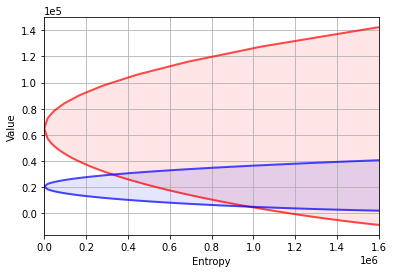

In [3]:
# Model parameters

a_0 = 100
a_1 = 0.5
ρ = 0.9
σ_d = 0.05
β = 0.95
c = 2
γ = 50.0

θ = 0.002
ac = (a_0 - c) / 2.0

# Define LQ matrices

R = np.array([[0.,   ac,   0.],
            [ac, -a_1,  0.5],
            [0.,  0.5,  0.]])

R = -R  # For minimization
Q = γ / 2

A = np.array([[1., 0., 0.],
            [0., 1., 0.],
            [0., 0., ρ]])
B = np.array([[0.],
            [1.],
            [0.]])
C = np.array([[0.],
            [0.],
            [σ_d]])

# ----------------------------------------------------------------------- #
#                                 Functions
# ----------------------------------------------------------------------- #


def evaluate_policy(θ, F):

    """
    Given θ (scalar, dtype=float) and policy F (array_like), returns the
    value associated with that policy under the worst case path for {w_t},
    as well as the entropy level.
    """

    rlq = qe.robustlq.RBLQ(Q, R, A, B, C, β, θ)
    K_F, P_F, d_F, O_F, o_F = rlq.evaluate_F(F)
    x0 = np.array([[1.], [0.], [0.]])
    value = - x0.T @ P_F @ x0 - d_F
    entropy = x0.T @ O_F @ x0 + o_F
    return list(map(float, (value, entropy)))


def value_and_entropy(emax, F, bw, grid_size=1000):

    """
    Compute the value function and entropy levels for a θ path
    increasing until it reaches the specified target entropy value.

    Parameters
    ==========
    emax: scalar
        The target entropy value

    F: array_like
        The policy function to be evaluated

    bw: str
        A string specifying whether the implied shock path follows best
        or worst assumptions. The only acceptable values are 'best' and
        'worst'.

    Returns
    =======
    df: pd.DataFrame
        A pandas DataFrame containing the value function and entropy
        values up to the emax parameter. The columns are 'value' and
        'entropy'.
    """

    if bw == 'worst':
        θs = 1 / np.linspace(1e-8, 1000, grid_size)
    else:
        θs = -1 / np.linspace(1e-8, 1000, grid_size)

    df = pd.DataFrame(index=θs, columns=('value', 'entropy'))

    for θ in θs:
        df.loc[θ] = evaluate_policy(θ, F)
        if df.loc[θ, 'entropy'] >= emax:
            break

    df = df.dropna(how='any')
    return df


# ------------------------------------------------------------------------ #
#                                    Main
# ------------------------------------------------------------------------ #


# Compute the optimal rule
optimal_lq = qe.lqcontrol.LQ(Q, R, A, B, C, beta=β)
Po, Fo, do = optimal_lq.stationary_values()

# Compute a robust rule given θ
baseline_robust = qe.robustlq.RBLQ(Q, R, A, B, C, β, θ)
Fb, Kb, Pb = baseline_robust.robust_rule()

# Check the positive definiteness of worst-case covariance matrix to
# ensure that θ exceeds the breakdown point
test_matrix = np.identity(Pb.shape[0]) - (C.T @ Pb @ C) / θ
eigenvals, eigenvecs = eig(test_matrix)
assert (eigenvals >= 0).all(), 'θ below breakdown point.'


emax = 1.6e6

optimal_best_case = value_and_entropy(emax, Fo, 'best')
robust_best_case = value_and_entropy(emax, Fb, 'best')
optimal_worst_case = value_and_entropy(emax, Fo, 'worst')
robust_worst_case = value_and_entropy(emax, Fb, 'worst')

fig, ax = plt.subplots()

ax.set_xlim(0, emax)
ax.set_ylabel("Value")
ax.set_xlabel("Entropy")
ax.grid()

for axis in 'x', 'y':
    plt.ticklabel_format(style='sci', axis=axis, scilimits=(0, 0))

plot_args = {'lw': 2, 'alpha': 0.7}

colors = 'r', 'b'

df_pairs = ((optimal_best_case, optimal_worst_case),
            (robust_best_case, robust_worst_case))


class Curve:

    def __init__(self, x, y):
        self.x, self.y = x, y

    def __call__(self, z):
        return np.interp(z, self.x, self.y)


for c, df_pair in zip(colors, df_pairs):
    curves = []
    for df in df_pair:
        # Plot curves
        x, y = df['entropy'], df['value']
        x, y = (np.asarray(a, dtype='float') for a in (x, y))
        egrid = np.linspace(0, emax, 100)
        curve = Curve(x, y)
        print(ax.plot(egrid, curve(egrid), color=c, **plot_args))
        curves.append(curve)
    # Color fill between curves
    ax.fill_between(egrid,
                    curves[0](egrid),
                    curves[1](egrid),
                    color=c, alpha=0.1)

plt.show()

Here's another such figure, with $\theta = 0.002$ instead of $0.02$

```{figure} /_static/lecture_specific/robustness/kg_small_theta.png

```

Can you explain the different shape of the value-entropy correspondence for the robust policy?

(rb_appendix)=
## Appendix

We sketch the proof only of the first claim in {ref}`this section <rb_eq>`,
which is that, for any given $\theta$, $K(\hat F, \theta) = \hat K$,
where $\hat K$ is as given in {eq}`rb_kd`.

This is the content of the next lemma.

**Lemma.** If $\hat P$ is the fixed point of the map $\mathcal B \circ \mathcal D$ and $\hat F$ is the robust policy as given in {eq}`rb_oc_ih`, then

```{math}
:label: rb_kft

K(\hat F, \theta) = (\theta I - C'\hat P C)^{-1} C' \hat P  (A - B \hat F)
```

*Proof:* As a first step, observe that when $F = \hat F$, the Bellman equation associated with the LQ problem  {eq}`rob_lomf` -- {eq}`rb_a2o` is

```{math}
:label: rb_a2be

\tilde P = -R - \hat F' Q \hat F -
\beta^2 (A - B \hat F)' \tilde P C
(\beta \theta I + \beta C' \tilde P C)^{-1} C' \tilde P (A - B \hat F) +
\beta (A - B \hat F)' \tilde P (A - B \hat F)
```

(revisit [this discussion](https://python-intro.quantecon.org/lqcontrol.html#Infinite-Horizon) if you don't know where {eq}`rb_a2be` comes from) and the optimal policy is

$$
w_{t+1} = - \beta (\beta \theta I + \beta C' \tilde P C)^{-1}
C' \tilde P (A - B \hat F) x_t
$$

Suppose for a moment that $- \hat P$ solves the Bellman equation {eq}`rb_a2be`.

In this case, the policy becomes

$$
w_{t+1} = (\theta I - C' \hat P C)^{-1} C' \hat P (A - B \hat F) x_t
$$

which is exactly the claim in {eq}`rb_kft`.

Hence it remains only to show that $- \hat P$ solves {eq}`rb_a2be`,
or, in other words,

$$
\hat  P =
R + \hat F' Q \hat F +
\beta (A - B \hat F)' \hat P C
(\theta I - C' \hat P C)^{-1} C' \hat P (A - B \hat F) +
\beta (A - B \hat F)' \hat P (A - B \hat F)
$$

Using the definition of $\mathcal D$, we can rewrite the right-hand
side more simply as

$$
R + \hat F' Q \hat F +
\beta (A - B \hat F)' \mathcal D(\hat P) (A - B \hat F)
$$

Although it involves a substantial amount of algebra, it can be shown that the
latter is just $\hat P$.

(Hint: Use the fact that $\hat P = \mathcal B( \mathcal D( \hat P))$)